Load data and preprocess

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

train_path = os.path.join(os.getcwd(), '../train_human.csv')
# train_path = os.path.join(os.getcwd(), '../train_canine_shuffled.csv')"

x_train = pd.read_csv(train_path,header=None,usecols=range(187))
y_train = pd.read_csv(train_path,header=None,usecols=[187]).iloc[:,0]
x_train.shape

test_path = os.path.join(os.getcwd(), '../test_human.csv')
# test_path = os.path.join(os.getcwd(), '../test_canine_shuffled.csv')"

x_test = pd.read_csv(test_path,header=None,usecols=range(187))
y_test = pd.read_csv(test_path,header=None,usecols=[187]).iloc[:,0]
x_test.shape

num_classes = 5 # 3, 5

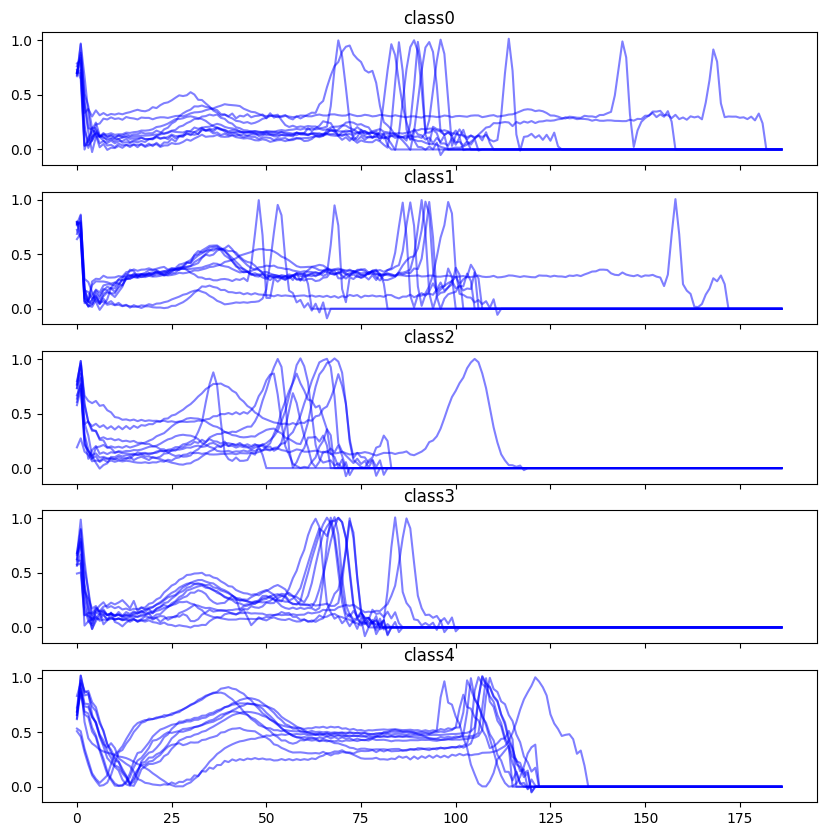

In [15]:
def plot(x_data, y_data, classes=range(num_classes), plots_per_class=10):

    f, ax = plt.subplots(num_classes, sharex=True, sharey=True, figsize=(10,10))
    for i in classes:
        for j in range(plots_per_class):
            ax[i].set_title("class{}".format(i))
            ax[i].plot(x_data[y_data == i].iloc[j,:], color="blue", alpha=.5)

           
plot(x_train, y_train)

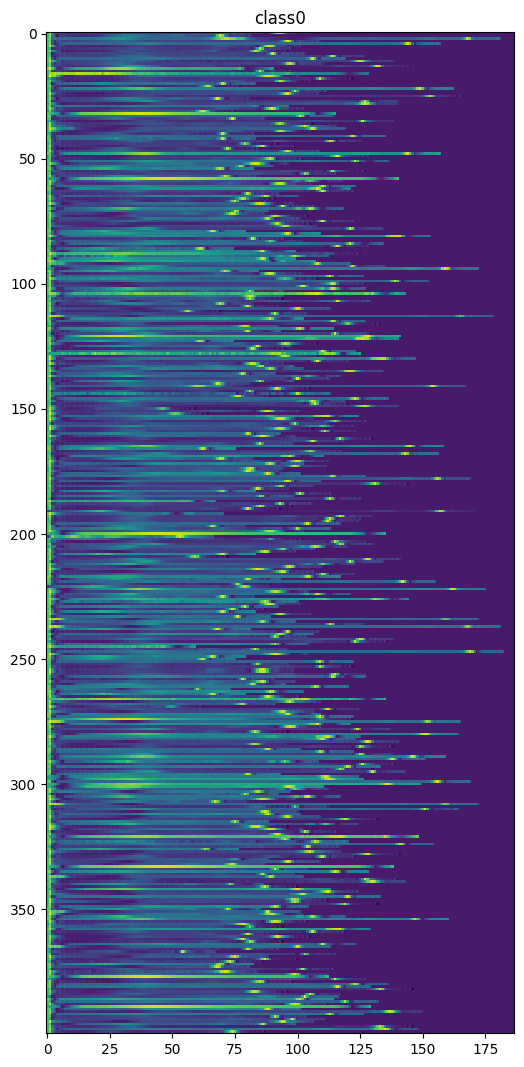

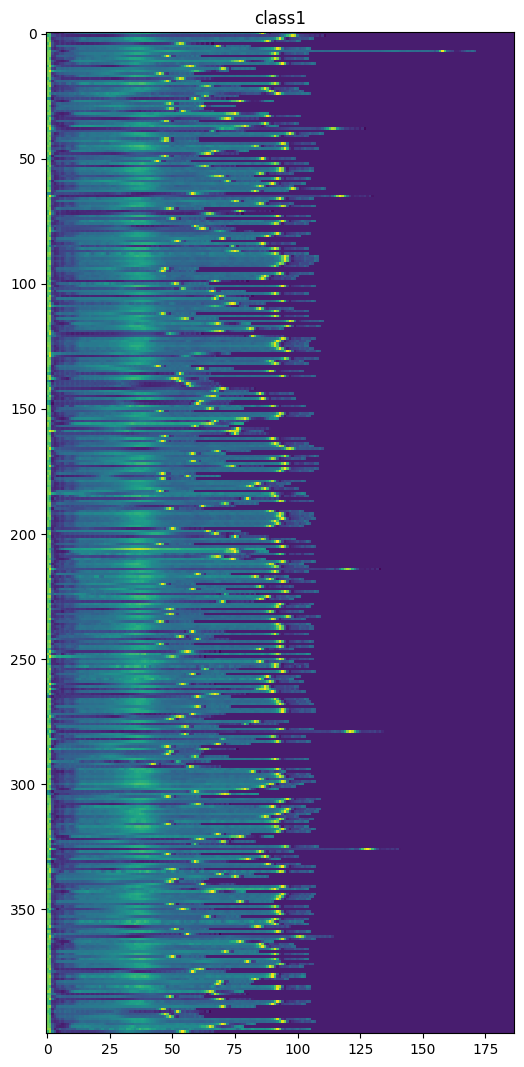

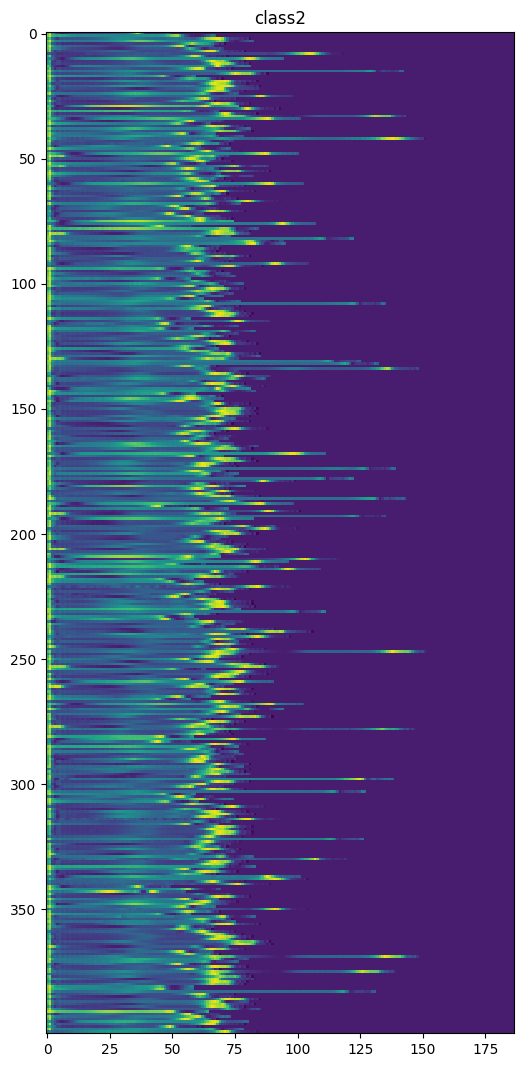

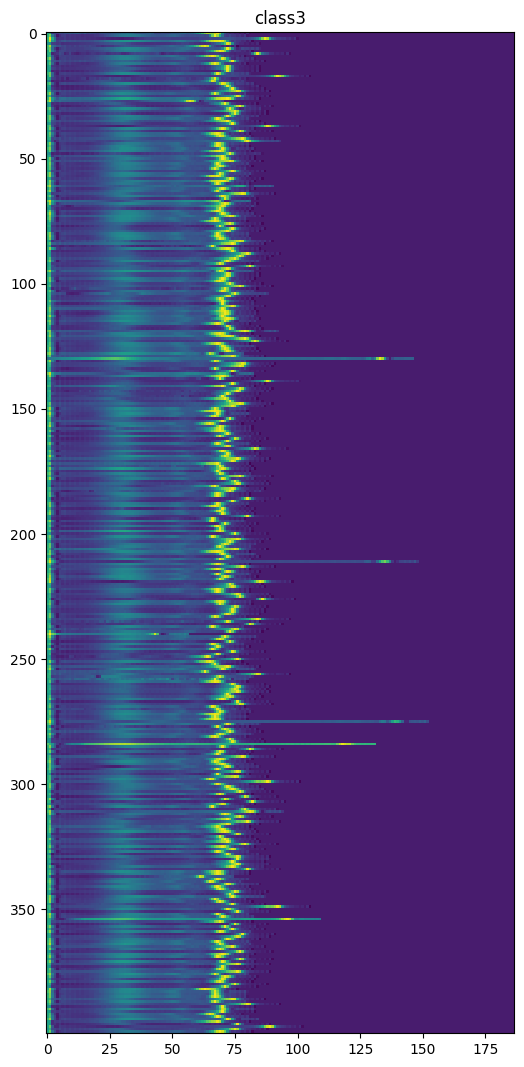

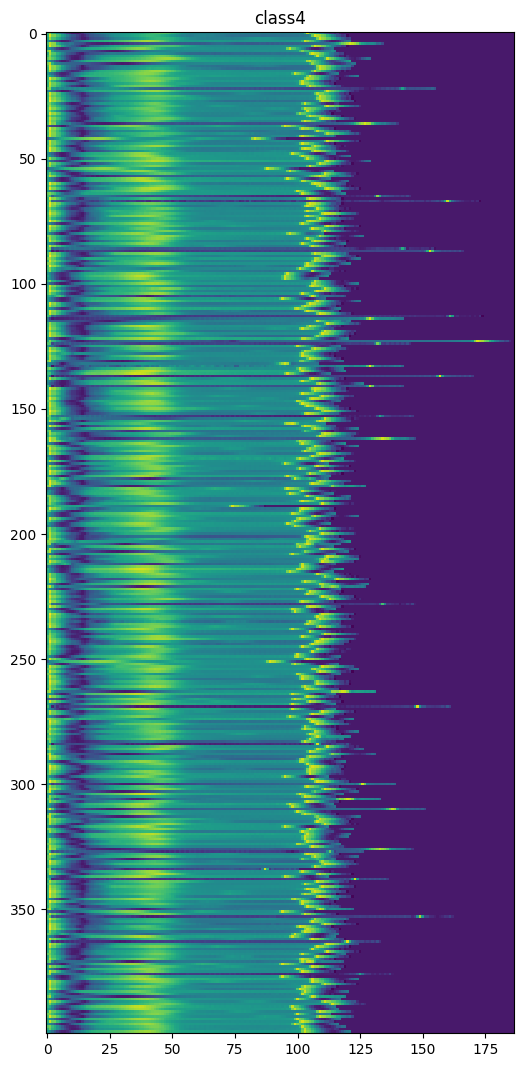

In [16]:
def class_spec(data, classnumber, n_samples):

    fig = plt.figure(figsize=(10,13))
    if type(data)==pd.DataFrame:        
        plt.imshow(data[y_train==classnumber].iloc[:n_samples,:], 
               cmap="viridis", interpolation="nearest")
    else:
        plt.imshow(data[y_train==classnumber][:n_samples,:], 
               cmap="viridis", interpolation="nearest")
    plt.title("class{}".format(classnumber))
    plt.show()
    
for i in range(num_classes):
    class_spec(x_train, i, 400)

C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\1416665136.py:7: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gauss = gaussian(window ,std, sym=True)


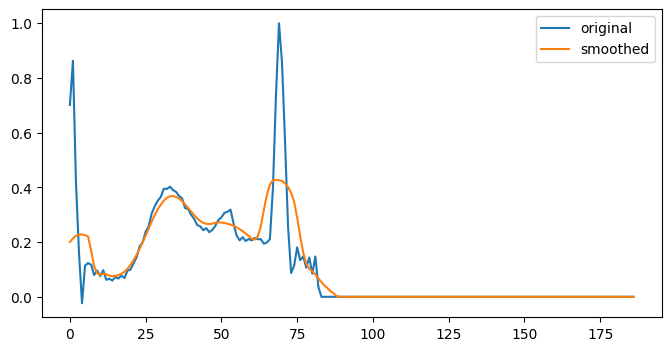

In [18]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset

def gaussian_smoothing(data, window, std):
    gauss = gaussian(window ,std, sym=True)
    data = np.convolve(gauss/gauss.sum(), data, mode='same')
    return data

def gauss_wrapper(data):
    return gaussian_smoothing(data, 12, 7)

fig = plt.figure(figsize=(8,4))
plt.plot(x_train.iloc[1,:], label="original")
plt.plot(gauss_wrapper(x_train.iloc[1,:]), label="smoothed")
plt.legend()

In [5]:
def gradient(data, normalize=True):
    data = data.diff(axis=1, periods=3)
    if normalize:
        data = data.apply(lambda x: x/x.abs().max(), axis=1)
    return data

def preprocess(data): 
    data = data.abs().rolling(7, axis=1).max()
    data = data.fillna(method="bfill",axis=1)
    # data = np.apply_along_axis(gauss_wrapper, 1, data)
    data = decimate(data, axis=1, q=5)
    data[np.abs(data) < .05] = 0
    return pd.DataFrame(data)

x_train_grad = gradient(x_train)
x_test_grad = gradient(x_test)

x_train_preprocessed = preprocess(pd.concat([x_train, x_train_grad, gradient(x_train_grad)], axis=1))
x_test_preprocessed = preprocess(pd.concat([x_test, x_test_grad, gradient(x_test_grad)], axis=1))

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_preprocessed.values.copy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.copy(), dtype=torch.long)
x_test_tensor = torch.tensor(x_test_preprocessed.values.copy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.copy(), dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\607463122.py:8: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  data = data.abs().rolling(7, axis=1).max()
C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\607463122.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="bfill",axis=1)
C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\607463122.py:8: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  data = data.abs().rolling(7, axis=1).max()
C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\607463122.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="bfill",axis=1)


Create CNN model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 25, 128) # Adjusted based on the flattened size
        self.fc2 = nn.Linear(128, num_classes) # 5 classes num_classes

    def forward(self, x):
        # print("Input shape:", x.shape)
        x = x.unsqueeze(1) # Add channel dimension
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print("Input shape:", x.shape)
        x = x.view(x.size(0), -1)
        # print("Input shape:", x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate model
model = ECG_CNN().to(device)


Using device: cuda


In [7]:
# Save the model weights as well as training history
import os
def save_model(model, optimiser, epoch, train_losses, val_losses, train_accuracies, val_accuracies, path='model.pt'):
    save_path = os.path.join(os.getcwd(), path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimiser_state_dict': optimiser.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, save_path)

# Load the model
def load_model(model, optimiser, path='model.pt'):
    model_path = os.path.join(os.getcwd(), path)
    loaded_data = torch.load(model_path)
    model.load_state_dict(loaded_data['model_state_dict'])
    optimiser.load_state_dict(loaded_data['optimiser_state_dict'])
    epoch = loaded_data['epoch']
    train_losses = loaded_data['train_losses']
    val_losses = loaded_data['val_losses']
    train_accuracies = loaded_data['train_accuracies']
    val_accuracies = loaded_data['val_accuracies']
    return model, optimiser, epoch, train_losses, val_losses, train_accuracies, val_accuracies


Training and validation loop

Starting new training session
Epoch 1/100, Training Loss: 0.8102, Validation Loss: 0.5582
Epoch 2/100, Training Loss: 0.5214, Validation Loss: 0.4595
Epoch 3/100, Training Loss: 0.4332, Validation Loss: 0.3876
Epoch 4/100, Training Loss: 0.3663, Validation Loss: 0.3203
Epoch 5/100, Training Loss: 0.3349, Validation Loss: 0.3340
Epoch 6/100, Training Loss: 0.3033, Validation Loss: 0.3281
Epoch 7/100, Training Loss: 0.2839, Validation Loss: 0.2431
Epoch 8/100, Training Loss: 0.2719, Validation Loss: 0.2487
Epoch 9/100, Training Loss: 0.2563, Validation Loss: 0.2713
Epoch 10/100, Training Loss: 0.2409, Validation Loss: 0.2238
Epoch 11/100, Training Loss: 0.2286, Validation Loss: 0.2386
Epoch 12/100, Training Loss: 0.2191, Validation Loss: 0.2075
Epoch 13/100, Training Loss: 0.2122, Validation Loss: 0.2199
Epoch 14/100, Training Loss: 0.1999, Validation Loss: 0.2119
Epoch 15/100, Training Loss: 0.1922, Validation Loss: 0.1902
Epoch 16/100, Training Loss: 0.1871, Validation Loss: 0.2044
Epo

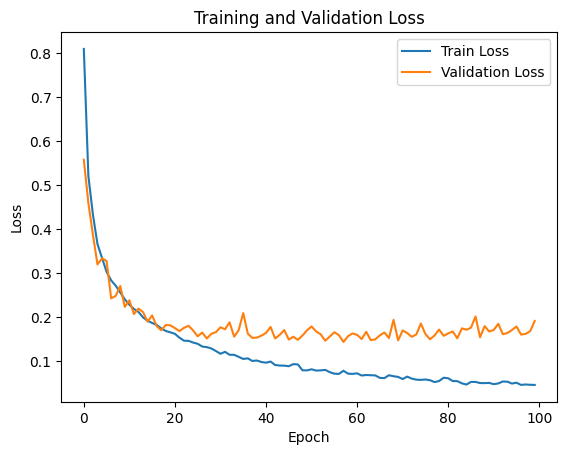

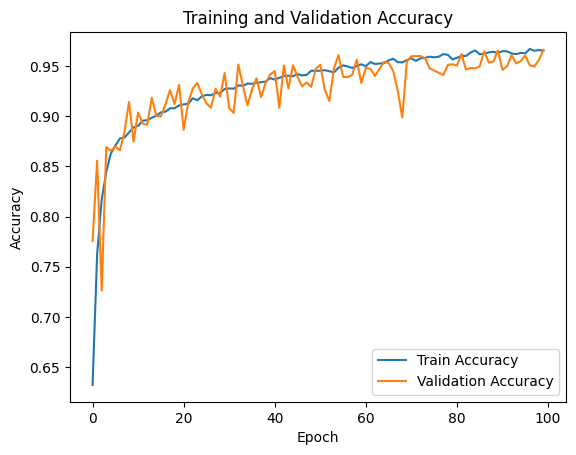

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report, accuracy_score, roc_curve, auc, average_precision_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import label_binarize
import torch.optim as optim
import os

# Uncomment for creating and training transfer learning model
# # Define the canine model and load pre-trained weights from the human model
# model_weights = torch.load('models/human_l20001_lr001_100.pt')
# model_state_dict = model_weights['model_state_dict']

# model.load_state_dict(model_state_dict, strict=False)
# model.fc2 = nn.Linear(128, 3)

# for name, param in model.named_parameters():
#     if 'fc2' not in name: # Freeze convolution layers
#         param.requires_grad = False

# model = model.to(device)


lambda_l2 = 0.0001 #0.0001
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=lambda_l2) # l2 regularisation

# Load model to continue training
model_path = 'models/canine_gradient.pt'
start_epoch = 0

# Check if the model exists to resume training
if os.path.exists(model_path):
    print("Loading model...")
    model, optimiser, start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_model(model, optimiser, model_path)
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("Starting new training session")
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Loss function with class weights, inversing sample size for each class
class_samples_inverse_train = [1/71702, 1/1819, 1/2952, 1/599, 1/3178] # human
# class_samples_inverse_train = [1/45509, 1/5519, 1/31814] # canine
class_weights_train = torch.tensor(class_samples_inverse_train, dtype=torch.float32).to(device)

class_samples_inverse_val = [1/17889, 1/482, 1/733, 1/151, 1/808] # human
# class_samples_inverse_val = [1/11555, 1/1299, 1/7857] # canine
class_weights_val = torch.tensor(class_samples_inverse_val, dtype=torch.float32).to(device)

criterion_train = nn.CrossEntropyLoss(weight=class_weights_train)
criterion_val = nn.CrossEntropyLoss(weight=class_weights_val)

# Training loop
n_epochs = 100 # Total, regardless of prior training
for epoch in range(start_epoch, n_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion_train(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion_val(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss for the epoch
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print both training and validation losses
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    

save_model(model, optimiser, n_epochs, train_losses, val_losses, train_accuracies, val_accuracies, path=f'models/human_sample_{n_epochs}.pt')

# Plotting losses and accuracy after training
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


View saved model loss and accuracy during training

Loading model...


C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\3979937024.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(model_path)


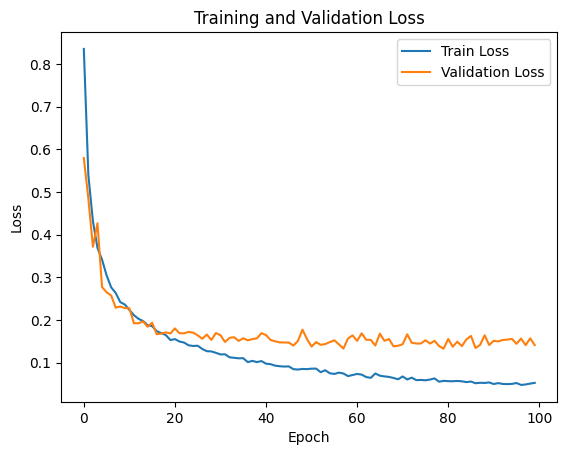

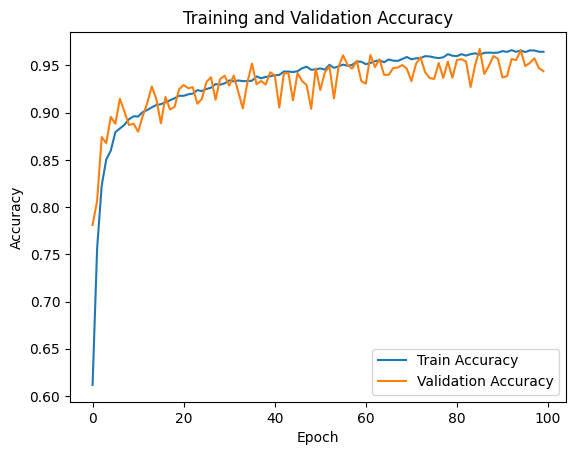

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report, accuracy_score, roc_curve, auc, average_precision_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import label_binarize
import torch.optim as optim
import os

lambda_l2 = 0.0001 #0.0001
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=lambda_l2)

# Load model if exists
model_path = 'models/human_l20001_lr001_100.pt'
# model_path = 'models/canine_lr0001_100.pt'
# model_path = 'models/canine_transfer_lr001_fix_100.pt'
start_epoch = 0

# Check if a model exists
if os.path.exists(model_path):
    print("Loading model...")
    model, optimiser, start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_model(model, optimiser, model_path)

# Plotting saved losses and accuracy
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Evaluation and model results

C:\Users\Jonah\AppData\Local\Temp\ipykernel_17248\3979937024.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(model_path)


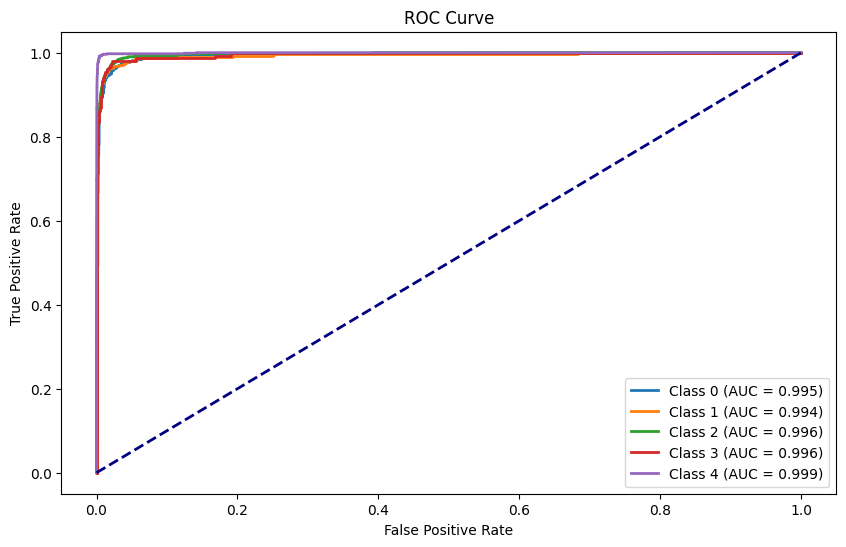

c:\Users\Jonah\Documents\School\UTS\Capstone\ecg-analysis\ecg-model\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jonah\Documents\School\UTS\Capstone\ecg-analysis\ecg-model\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jonah\Documents\School\UTS\Capstone\ecg-analysis\ecg-model\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

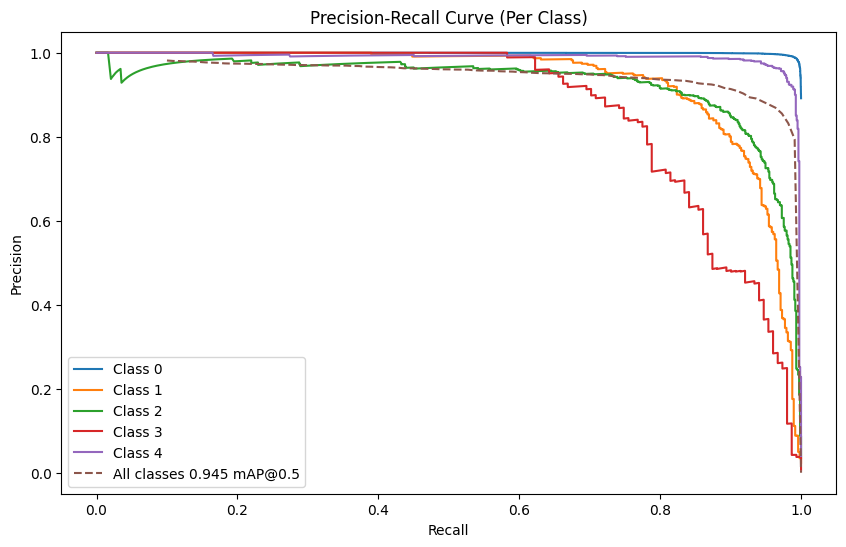

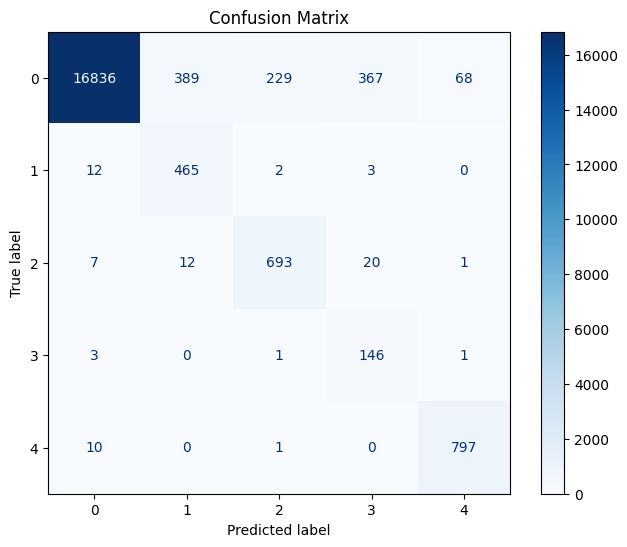

Accuracy: 0.9438767881174301
              precision    recall  f1-score   support

           0     0.9981    0.9411    0.9688     17889
           1     0.5370    0.9647    0.6899       482
           2     0.7484    0.9454    0.8354       733
           3     0.2724    0.9669    0.4250       151
           4     0.9193    0.9864    0.9516       808

    accuracy                         0.9439     20063
   macro avg     0.6950    0.9609    0.7742     20063
weighted avg     0.9693    0.9439    0.9524     20063



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, f1_score, recall_score, precision_score, precision_recall_fscore_support, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
from sklearn.preprocessing import label_binarize

# Testing human model on canine data (setup num_classes=5, load canine data, load saved human model to evaluate)
# TF learning, load canine data, num_classes=3, fix CNN to initalise with 5 classes, load saved model to train on

# model_path = 'models/canine_filter_gauss_shuffle_100.pt' # 99.8
# model_path = 'models/canine_filter_gauss_shuffle_lr0005_200.pt' # 99.8
# model_path = 'models/canine_lr0001_100.pt' # 99.6 ######## best performing params for canine

model_path = 'models/human_l20001_lr001_100.pt' # 94 ######### best performing params for human
# model_path = 'models/human_l2001_lr001_fix_100.pt' # 91

# model_path = 'models/canine_transfer_unfreeze_lr0001_fix_100.pt' # 99.8 #same, transfer learning not really occurring here essentially forgetting and training like canine cnn
# model_path = 'models/canine_transfer_lr0001_fix_100.pt' # 90 # low learning rate doesnt help here as it does for pure canine cnn, because of frozen layers?
# model_path = 'models/canine_transfer_lr001_fix_100.pt' # 91.8 ### best tf model

# Comment out if not loading from file
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
model, _, _, _, _, _, _ = load_model(model, optimiser, model_path)

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    probabilities = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)

        probabilities.append(prob.cpu().numpy())
        _, predicted = torch.max(prob, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Probabilities for ROC and Precision-Recall curves
probabilities = np.concatenate(probabilities, axis=0)

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
# y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# ROC Curve
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true == i, probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


thresholds = np.linspace(0.1, 1.0, 100)
# Initialising to store metrics for each class at each threshold
f1_scores_threshold = {i: [] for i in range(num_classes)}
precision_scores_threshold = {i: [] for i in range(num_classes)}
recall_scores_threshold = {i: [] for i in range(num_classes)}

# Loop through each threshold to compute metrics for each class
for threshold in thresholds:
    y_pred_class = (probabilities >= threshold).astype(int)
    
    for i in range(num_classes):
        # F1 Score
        f1 = f1_score(y_true == i, y_pred_class[:, i], average='binary')
        f1_scores_threshold[i].append(f1)
        
        # Precision
        precision = precision_score(y_true == i, y_pred_class[:, i], average='binary')
        precision_scores_threshold[i].append(precision)
        
        # Recall
        recall = recall_score(y_true == i, y_pred_class[:, i], average='binary')
        recall_scores_threshold[i].append(recall)

# Average F1 score, Precision, Recall across all classes for each threshold
avg_f1_scores = np.mean(list(f1_scores_threshold.values()), axis=0)
avg_precision_scores = np.mean(list(precision_scores_threshold.values()), axis=0)
avg_recall_scores = np.mean(list(recall_scores_threshold.values()), axis=0)


# Precision-Recall Curve for each class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probabilities[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
mean_ap_at_0_5 = np.mean([average_precision_score(y_true_bin[:, i], probabilities[:, i]) for i in range(num_classes)]) # Calculate mAP at IoU threshold 0.5
plt.plot(thresholds, avg_recall_scores, label=f'All classes {mean_ap_at_0_5:.3f} mAP@0.5', linestyle='--') # Plot the average line
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Per Class)')
plt.legend(loc="lower left")
plt.show()

# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2, 3, 4])
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2])
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()

# Evaluation report
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))



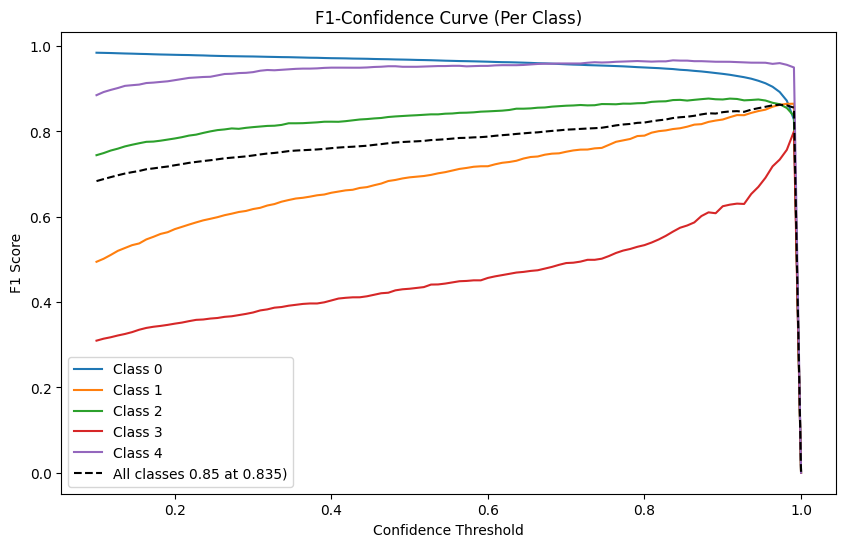

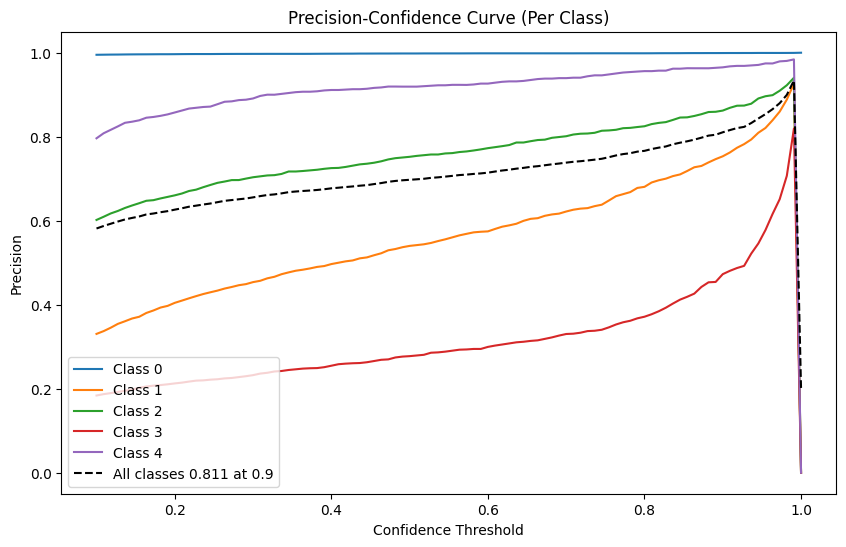

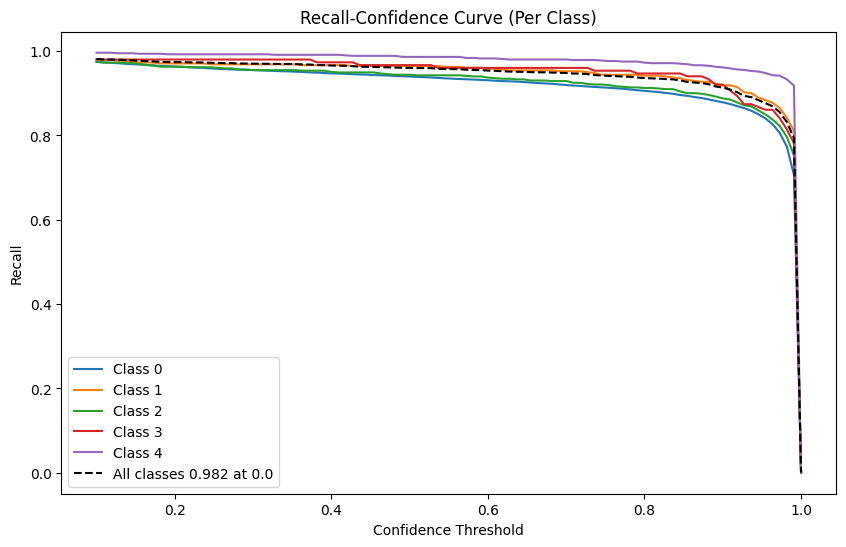

In [13]:
### Below metrics maybe not so useful
# F1-Confidence Curve for each class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(thresholds, f1_scores_threshold[i], label=f'Class {i}')
f1_85_threshold =  np.mean([f1_scores_threshold[i][np.argmin(np.abs(thresholds - 0.85))] for i in range(num_classes)]) # Find F1 at threshold 0.85
plt.plot(thresholds, avg_f1_scores, 'k--', label=f'All classes 0.85 at {f1_85_threshold:.3f})') # Plot the average F1 line
plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1-Confidence Curve (Per Class)')
plt.legend()
plt.show()

# Precision-Confidence Curve for each class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(thresholds, precision_scores_threshold[i], label=f'Class {i}')
precision_at_0_9 = np.mean([precision_scores_threshold[i][np.argmin(np.abs(thresholds - 0.9))] for i in range(num_classes)]) # Find precision at threshold 0.9
plt.plot(thresholds, avg_precision_scores, 'k--', label=f'All classes {precision_at_0_9:.3f} at 0.9') # Plot the average Precision line
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision-Confidence Curve (Per Class)')
plt.legend(loc="lower left")
plt.show()

# Recall-Confidence Curve for each class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(thresholds, recall_scores_threshold[i], label=f'Class {i}')
recall_at_0_0 = np.mean([recall_scores_threshold[i][np.argmin(np.abs(thresholds - 0.0))] for i in range(num_classes)]) # Find recall at threshold 0.0
plt.plot(thresholds, avg_recall_scores, 'k--', label=f'All classes {recall_at_0_0:.3f} at 0.0') # Plot the average Recall line
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall-Confidence Curve (Per Class)')
plt.legend(loc="lower left")
plt.show()
